In [ ]:
!pip install -q tflite-model-maker
!pip install -q -U tensorflow-datasets

In [ ]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_examples.lite.model_maker.core.export_format import ExportFormat
from tensorflow_examples.lite.model_maker.core.task import image_preprocessing

from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker.image_classifier import ModelSpec

## STEP1. TFDS 데이터화

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/content/drive/MyDrive/ColabNotebooks/Age_estimation_dataset',
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=6000, num_shards=1>,
        'train': <SplitInfo num_examples=17999, num_shards=1>,
        'validation': <SplitInfo num_examples=6000, num_shards=1>,
    },
    citation="""""",
)


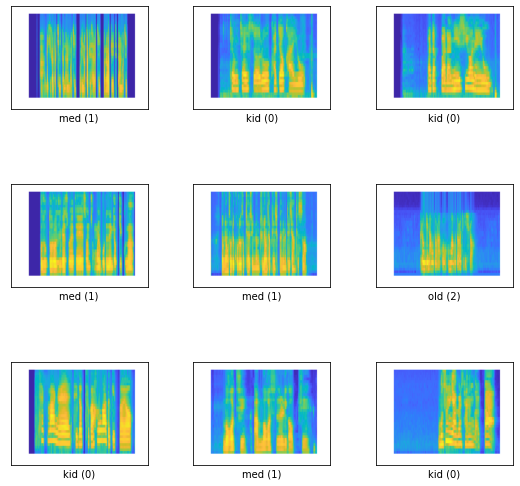

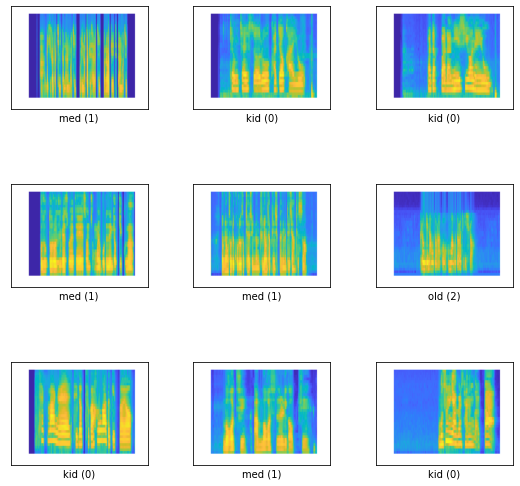

In [ ]:
#이미지에 라벨링 작업
data_root_dir = '/content/drive/MyDrive/ColabNotebooks/Age_estimation_dataset'

builder = tfds.ImageFolder(data_root_dir)

ds_info = builder.info
ds_train = builder.as_dataset(split='train', as_supervised=True)
ds_validation = builder.as_dataset(split='validation', as_supervised=True)
ds_test = builder.as_dataset(split='test', as_supervised=True)

print(ds_info)
tfds.show_examples(ds_train, builder.info)

##STEP2. TFDS 데이터 세트에서 알 수 없는 예시로 사용할 이미지 추가

In [ ]:
UNKNOWN_TFDS_DATASETS = [{
    'tfds_name': 'imagenet_v2/matched-frequency',
    'train_split': 'test[:80%]',
    'test_split': 'test[80%:]',
    'num_examples_ratio_to_normal': 1.0,
}, {
    'tfds_name': 'oxford_flowers102',
    'train_split': 'train',
    'test_split': 'test',
    'num_examples_ratio_to_normal': 1.0,
}, {
    'tfds_name': 'beans',
    'train_split': 'train',
    'test_split': 'test',
    'num_examples_ratio_to_normal': 1.0,
}]

In [ ]:
# 알수 없음 데이터셋 불러오기
weights = [
    spec['num_examples_ratio_to_normal'] for spec in UNKNOWN_TFDS_DATASETS
]
num_unknown_train_examples = sum(
    int(w * ds_train.cardinality().numpy()) for w in weights)
ds_unknown_train = tf.data.experimental.sample_from_datasets([
    tfds.load(
        name=spec['tfds_name'], split=spec['train_split'],
        as_supervised=True).repeat(-1) for spec in UNKNOWN_TFDS_DATASETS
], weights).take(num_unknown_train_examples)
ds_unknown_train = ds_unknown_train.apply(
    tf.data.experimental.assert_cardinality(num_unknown_train_examples))
ds_unknown_tests = [
    tfds.load(
        name=spec['tfds_name'], split=spec['test_split'], as_supervised=True)
    for spec in UNKNOWN_TFDS_DATASETS
]
ds_unknown_test = ds_unknown_tests[0]
for ds in ds_unknown_tests[1:]:
  ds_unknown_test = ds_unknown_test.concatenate(ds)

# All examples from the unknown datasets will get a new class label number.
num_normal_classes = len(ds_info.features['label'].names)
unknown_label_value = tf.convert_to_tensor(num_normal_classes, tf.int64)
ds_unknown_train = ds_unknown_train.map(lambda image, _:
                                        (image, unknown_label_value))
ds_unknown_test = ds_unknown_test.map(lambda image, _:
                                      (image, unknown_label_value))

# Merge the normal train dataset with the unknown train dataset.
weights = [
    ds_train.cardinality().numpy(),
    ds_unknown_train.cardinality().numpy()
]
ds_train_with_unknown = tf.data.experimental.sample_from_datasets(
    [ds_train, ds_unknown_train], [float(w) for w in weights])
ds_train_with_unknown = ds_train_with_unknown.apply(
    tf.data.experimental.assert_cardinality(sum(weights)))

print((f"Added {ds_unknown_train.cardinality().numpy()} negative examples."
       f"Training dataset has now {ds_train_with_unknown.cardinality().numpy()}"
       ' examples in total.'))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling imagenet_v2-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset imagenet_v2 downloaded and prepared to /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling oxford_flowers102-train.tfrecord...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling oxford_flowers102-test.tfrecord...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling oxford_flowers102-validation.tfrecord...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling beans-train.tfrecord...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling beans-validation.tfrecord...:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling beans-test.tfrecord...:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.random(...)`.


Instructions for updating:
Use `tf.data.Dataset.random(...)`.


Added 53997 negative examples.Training dataset has now 71996 examples in total.


## STEP3. 증강 적용

### 모든 이미지에 대해 더 다양하게 만들기 위해 다음과 같은 변경 사항과 같은 일부 Augmentation를 적용합니다.

*   명도
*   대조
*   포화
*   색조
*   자르기





In [ ]:
def random_crop_and_random_augmentations_fn(image):
  # train data 명도/대조값/포화값/색조값 조절하기
  image = image_preprocessing.preprocess_for_train(image)
  image = tf.image.random_brightness(image, 0.2)
  image = tf.image.random_contrast(image, 0.5, 2.0)
  image = tf.image.random_saturation(image, 0.75, 1.25)
  image = tf.image.random_hue(image, 0.1)
  return image


def random_crop_fn(image):
  # train data 랜덤으로 사이즈 조정과 자르기
  image = image_preprocessing.preprocess_for_train(image)
  return image


def resize_and_center_crop_fn(image):
  image = tf.image.resize(image, (256, 256))
  image = image[16:240, 16:240]
  return image


no_augment_fn = lambda image: image

train_augment_fn = lambda image, label: (
    random_crop_and_random_augmentations_fn(image), label)
eval_augment_fn = lambda image, label: (resize_and_center_crop_fn(image), label)

In [ ]:
#증강을 적용하기 위해 Dataset 클래스의 map 메서드를 사용.

ds_train_with_unknown = ds_train_with_unknown.map(train_augment_fn)
ds_validation = ds_validation.map(eval_augment_fn)
ds_test = ds_test.map(eval_augment_fn)
ds_unknown_test = ds_unknown_test.map(eval_augment_fn)

INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


## STEP4. 데이터를 Model Maker 친화적인 형식으로 래핑

In [ ]:
label_names = ds_info.features['label'].names + ['UNKNOWN']

train_data = ImageClassifierDataLoader(ds_train_with_unknown,
                                       ds_train_with_unknown.cardinality(),
                                       label_names)
validation_data = ImageClassifierDataLoader(ds_validation,
                                            ds_validation.cardinality(),
                                            label_names)
test_data = ImageClassifierDataLoader(ds_test, ds_test.cardinality(),
                                      label_names)
unknown_test_data = ImageClassifierDataLoader(ds_unknown_test,
                                              ds_unknown_test.cardinality(),
                                              label_names)

print(label_names)

['kid', 'med', 'old', 'UNKNOWN']


## STEP5. Model Fitting

### TFHub의 tranfer model 중 mobilenet_v3사용

In [ ]:
model_name = 'mobilenet_v3_large_100_224' 

map_model_name = {
    'cropnet_concat':
        'https://tfhub.dev/google/cropnet/feature_vector/concat/1',
    'cropnet_imagenet':
        'https://tfhub.dev/google/cropnet/feature_vector/imagenet/1',
    'mobilenet_v3_large_100_224':
        'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5',
}

model_handle = map_model_name[model_name]

In [ ]:
image_model_spec = ModelSpec(uri=model_handle)

In [ ]:
model = image_classifier.create(
    train_data,
    model_spec=image_model_spec,
    batch_size=128,
    learning_rate=0.03,
    epochs=5,
    shuffle=True,
    train_whole_model=True,
    validation_data=validation_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              4226432   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 4,231,556
Trainable params: 4,207,156
Non-trainable params: 24,400
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
562/562 [==============================] - 1659s 3s/step - loss: 0.6717 - accuracy: 0.9689 - val_loss: 1.0971 - val_accuracy: 0.8083
Epoch 2/5
562/562 [==============================] - 320s 570ms/step - loss: 0.6370 - accuracy: 0.9838 - val_loss: 0.8004 - val_accuracy: 0.8991
Epoch 3/5
562/562 [==============================] - 324s 577ms/step - loss: 0.6229 - accuracy: 0.9868 - val_loss: 0.7936 - val_accuracy: 0.8927
Epoch 4/5
562/562 [==============================] - 323s 575ms/step - loss: 0.6155 - accuracy: 0.9893 - val_loss: 0.7826 - val_accuracy: 0.9015
Epoch 5/5
562/562 [==============================] - 320s 569ms/step - loss: 0.6092 - accuracy: 0.9905 - val_loss: 0.7577 - val_accuracy: 0.9098


## STEP6. Test 정확도 및 Confusion Matrix 확인

In [ ]:
model.evaluate(test_data)

188/188 [==============================] - 457s 2s/step - loss: 2.2301 - accuracy: 0.4247


[2.2301323413848877, 0.4246666729450226]

In [ ]:
def predict_class_label_number(dataset):
  """Runs inference and returns predictions as class label numbers."""
  rev_label_names = {l: i for i, l in enumerate(label_names)}
  return [
      rev_label_names[o[0][0]]
      for o in model.predict_top_k(dataset, batch_size=128)
  ]

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

#### **Test Data 6000개 中**

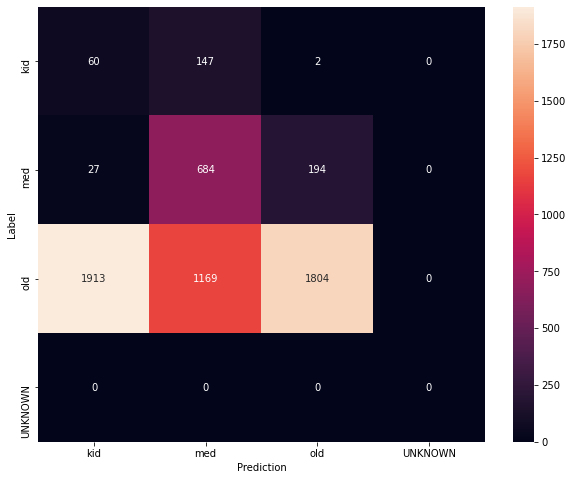

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    predict_class_label_number(test_data),
    list(ds_test.map(lambda x, y: y)),
    num_classes=len(label_names))

show_confusion_matrix(confusion_mtx, label_names)

### 알 수 없는 Test Data 혼동행렬

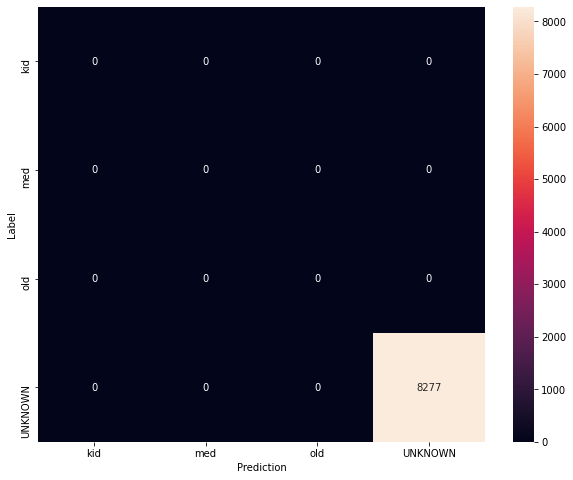

In [ ]:
unknown_confusion_mtx = tf.math.confusion_matrix(
    predict_class_label_number(unknown_test_data),
    list(ds_unknown_test.map(lambda x, y: y)),
    num_classes=len(label_names))

show_confusion_matrix(unknown_confusion_mtx, label_names)

## Step 7. 모델 저장

In [ ]:
# Export saved model version.
model.export(export_dir='/content/drive/MyDrive/ColabNotebooks/무곤스 몰래 만드는 폴더/BroadCnS/TFHub_Transfer_Learning', export_format=ExportFormat.SAVED_MODEL)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ColabNotebooks/무곤스 몰래 만드는 폴더/BroadCnS/TFHub_Transfer_Learning/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ColabNotebooks/무곤스 몰래 만드는 폴더/BroadCnS/TFHub_Transfer_Learning/saved_model/assets
